<font color="red">**Disclaimer**: The author of this exercise has been fired because he made a fundamental machine learning mistake when creating this Jupyter Notebook.</font>

> Your task is to find the mistake the data scientist made and submit the answer on ILIAS.

# Debugging Decision Trees and Random Forest

In todays exercise we want to predict car prices from the AutoScout24 dataset by using a Decision Tree and Random Forest.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from tqdm.notebook import tqdm

## Load the dataset
We are going to use the AutoScout24 dataset and apply the feature engineering we have developed in the previous exercises.

In [2]:
df = pd.read_csv("cars.csv")

df['Age'] = df.Year-1984
df['Brand'] = df.Name.str.split(' ').map(lambda x: x[0])
df.drop(['Name', 'Registration', 'Year'], axis='columns', inplace=True)
df.drop_duplicates(inplace=True)
df.drop([17010, 7734, 47002, 44369, 24720, 50574, 36542, 42611,
         22513, 12773, 21501, 2424, 52910, 29735, 43004, 47125], axis='rows', inplace=True)
df.drop(df.index[df.EngineSize > 7500], axis='rows', inplace=True)

df.head()

,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Age,Brand
0,44800,27600,anthrazit,2,320,4973,2,8,5,12,MERCEDES-BENZ
1,22800,18300,anthrazit,4,286,4398,5,8,5,15,BMW
2,183710,650,anthrazit,5,350,4172,5,8,6,24,AUDI
3,19900,32000,anthrazit,5,150,2198,7,4,6,22,OPEL
4,18999,118000,anthrazit,5,163,2401,5,5,5,19,VOLVO


### Normalize data, handle categorical data

In [3]:
df["Brand"] = df["Brand"].astype("category").cat.codes
df["Color"] = df["Color"].astype("category").cat.codes
df.head()

,Price,Mileage,Color,Doors,Horsepower,EngineSize,Seats,Cylinders,Gears,Age,Brand
0,44800,27600,0,2,320,4973,2,8,5,12,40
1,22800,18300,0,4,286,4398,5,8,5,15,5
2,183710,650,0,5,350,4172,5,8,6,24,3
3,19900,32000,0,5,150,2198,7,4,6,22,47
4,18999,118000,0,5,163,2401,5,5,5,19,66


### Split the data into train and test set

In [4]:
X = df.drop(columns=["Price"])
y = df["Price"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Decision Trees
We start by checking on how good decision trees perform on our dataset.
> Grow a decision tree for our training data.  Use a [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from Scikit-Learn.


In [6]:
dt = DecisionTreeRegressor(max_depth=30, min_samples_split=2, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=30, random_state=42)

> Now calculate the $R^2$ score on the training set.

In [7]:
y_pred = dt.predict(X_train)
r2_train = r2_score(y_train, y_pred)
print("r2 train:", r2_train)

r2 train: 0.9992472343502118


Wow, such a high score. Almost perfect... Now calculate the cross validation score using a 5-fold cross validation. 

> Perform a 5-fold cross validation by using  the [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from Scikit-Learn.

In [8]:
r2_cv = cross_val_score(dt, X_train, y_train, cv=5).mean()
print("r2 cv:", r2_cv)

r2 cv: 0.8675475309612265


Our CV-Score looks rather disappointing. How is this behaviour called?

### Plot the learning curve

To further investigate on how our model performs, we plot the so called learning curve. We use the [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) function from Scikit-Learn.

The learning curve shows the validation and the training score of our model for varying numbers of training samples. It is a nice tool to find out how much we benefit from adding more trianing data and wheter our model suffers from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

cross validation r2-score: 0.8675512989243213
training r2-score 0.9993663808535546


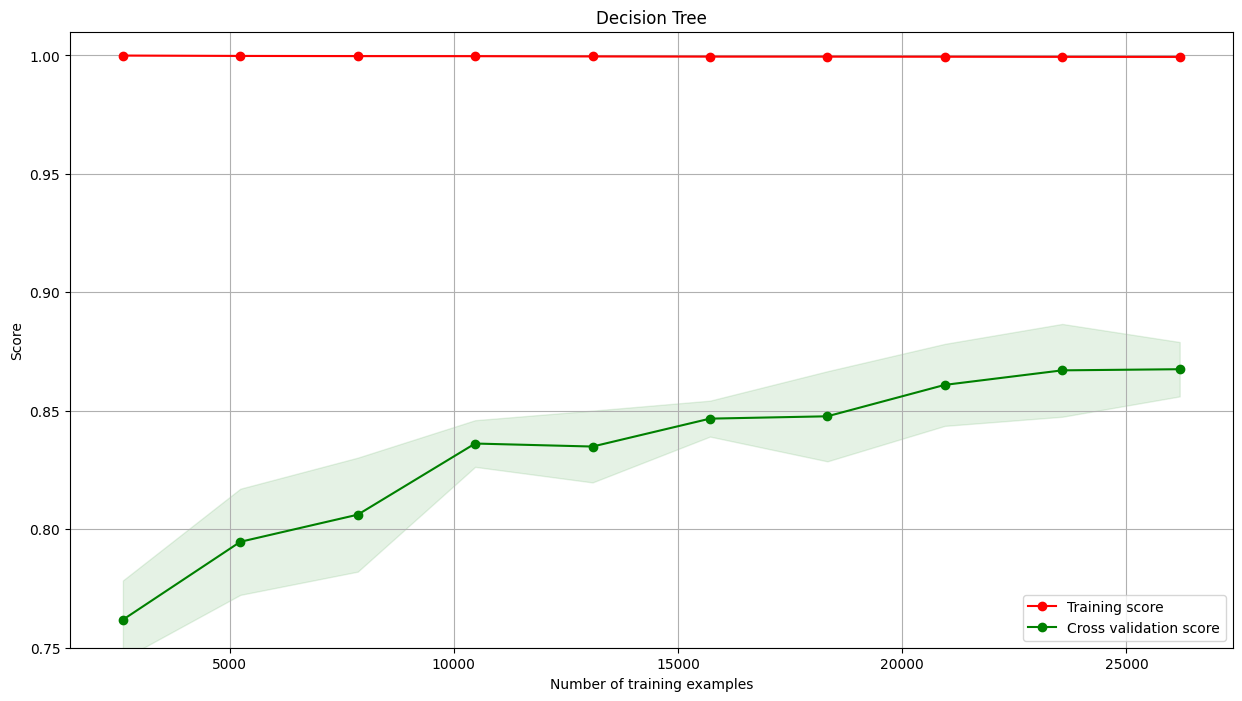

In [9]:
def plot_learning_curve(estimator, X, y, title):
    plt.figure(figsize=(15,8))
    plt.title(title)
    plt.xlabel("Number of training examples")
    plt.ylabel("Score")
    
    train_sizes = np.linspace(.1, 1.0, 10)
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator, X, y, cv=5, train_sizes=train_sizes, scoring="r2")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    plt.grid()
    plt.ylim(0.75, 1.01)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, cv_scores_mean - cv_scores_std,
                     cv_scores_mean + cv_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', color="g",
             label="Cross validation score")

    plt.legend(loc="best")
    
    print("cross validation r2-score:", cv_scores_mean[-1])
    print("training r2-score", train_scores_mean[-1])
    
plot_learning_curve(dt, X_train, y_train, "Decision Tree")

Our $R^2$ score on the training set is pretty high. We play around with the parameters `max_depth` and `min_samples_split` to close the gap between the training and CV-score.

In [10]:
parameters = {
    "max_depth": range(10, 21),
    "min_samples_split": [2, 3, 4, 5, 6, 7], 
    "random_state": [42]
}

gridSearch = GridSearchCV(dt, parameters, cv=5, scoring="r2")
gridSearch.fit(X_test, y_test) ## HERE WE SHOULD NOT USE THE TEST SET!

print("Best score", gridSearch.best_score_)
print("Best params", gridSearch.best_params_)

Best score 0.8442597631094749
Best params {'max_depth': 11, 'min_samples_split': 7, 'random_state': 42}


We can access the best decision tree by means of the attribute `best_estimator_`.

In [11]:
dt = gridSearch.best_estimator_

Let us plot the learning curve again.

cross validation r2-score: 0.8798042877342873
training r2-score 0.9527663771803834


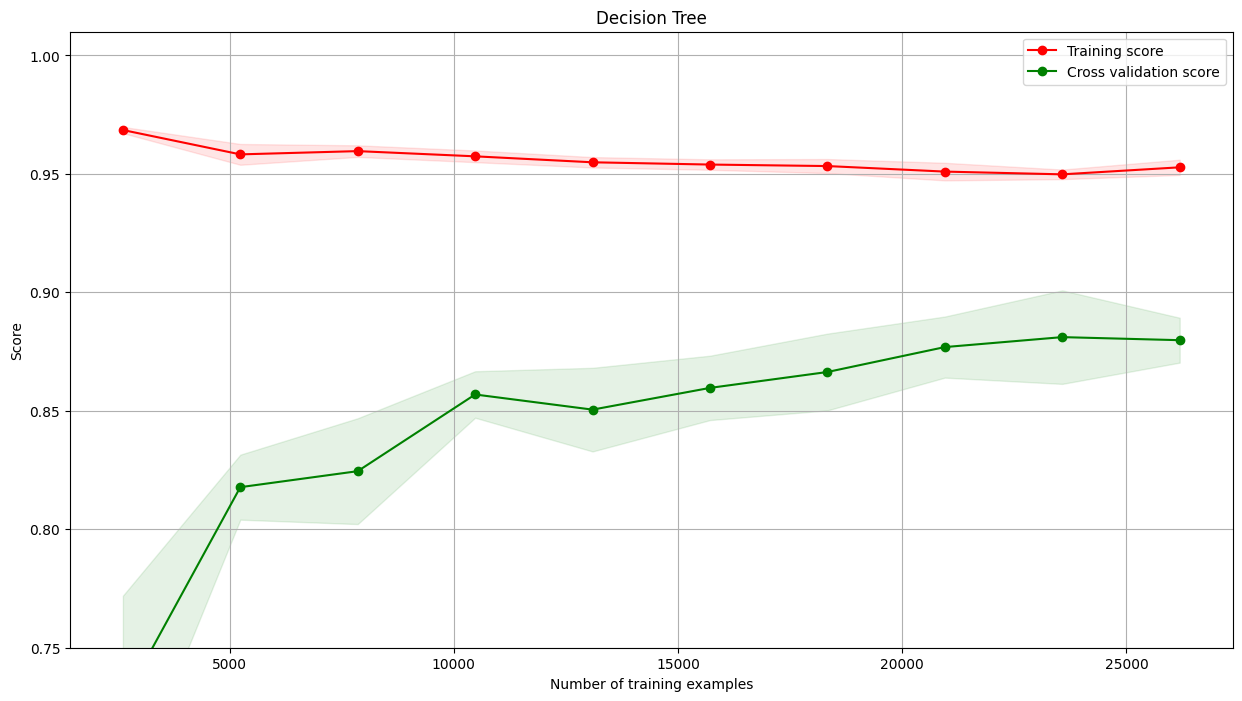

In [12]:
plot_learning_curve(dt, X_train, y_train, "Decision Tree")

### Evaluate the performance on the test set

Now that we have chosen the optimal hyperparameters for out tree, let's check how good our model performs on the test set.

In [13]:
y_pred = dt.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2:", r2)

r2: 0.9509356282111695


### Examine our tree
Let us check how our grown decision tree looks like.

In [14]:
print("Number of nodes:", dt.tree_.node_count)
print("Depth:", dt.tree_.max_depth)

Number of nodes: 1847
Depth: 11


#### Plot our tree (Optional)
Scikit-Learn version 0.21 provides a cool new function `plot_tree` which allows us to easily visualize our Decision Tree. To run the following cell, make sure that your Scikit-Learn version is up to date.

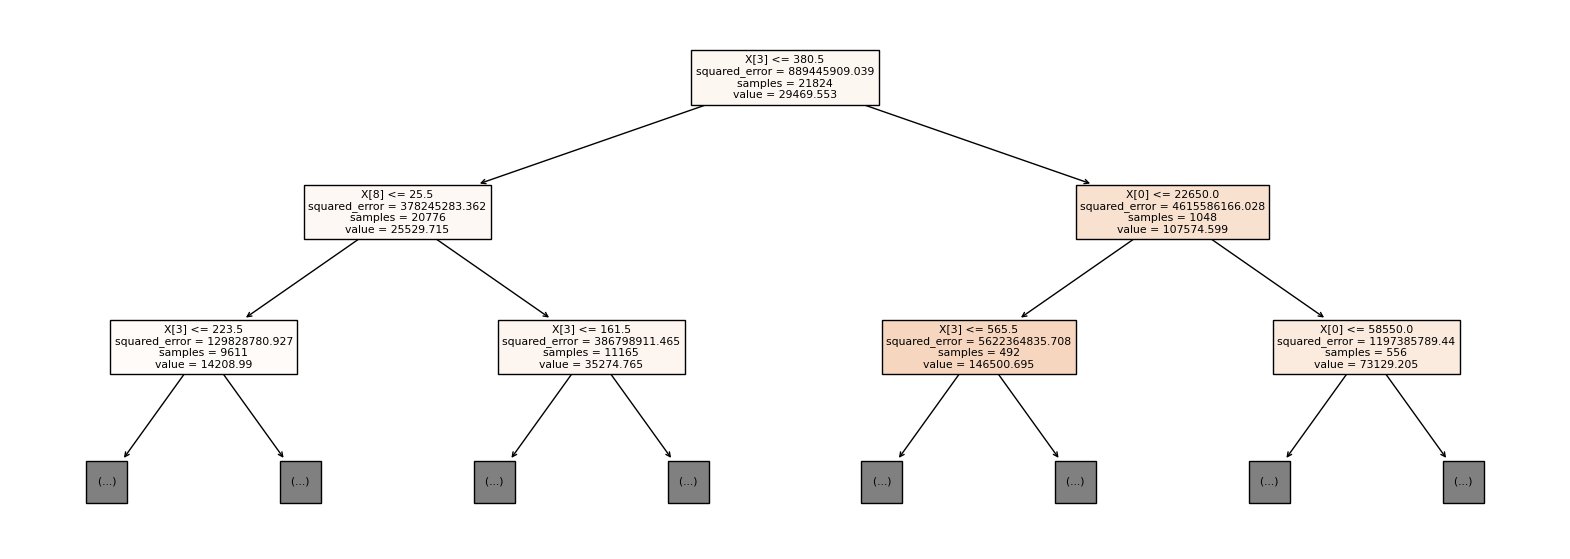

In [16]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,7))
plot_tree(dt, max_depth=2, filled=True)
plt.show()

In our plot we can see that the first splits were made based on the features with indices 3 and 8. What kind of features are these?

In [17]:
print("Feature 3:", X_train.columns[3])
print("Feature 8:", X_train.columns[8])

Feature 3: Horsepower
Feature 8: Age


It seems like the features *Horsepower* and *Age* are somehow important. Our estimator stores the importance of each feature in the attribute `feature_importances_`. Note that the values should sum up to 1.

In [22]:
dt.feature_importances_

array([0.12611786, 0.00388869, 0.00392175, 0.58854441, 0.08925584,
       0.00500304, 0.00474924, 0.01195664, 0.15050003, 0.0160625 ])

In [24]:
dt.feature_importances_.sum()

1.0000000000000002

We can plot these feature importances.

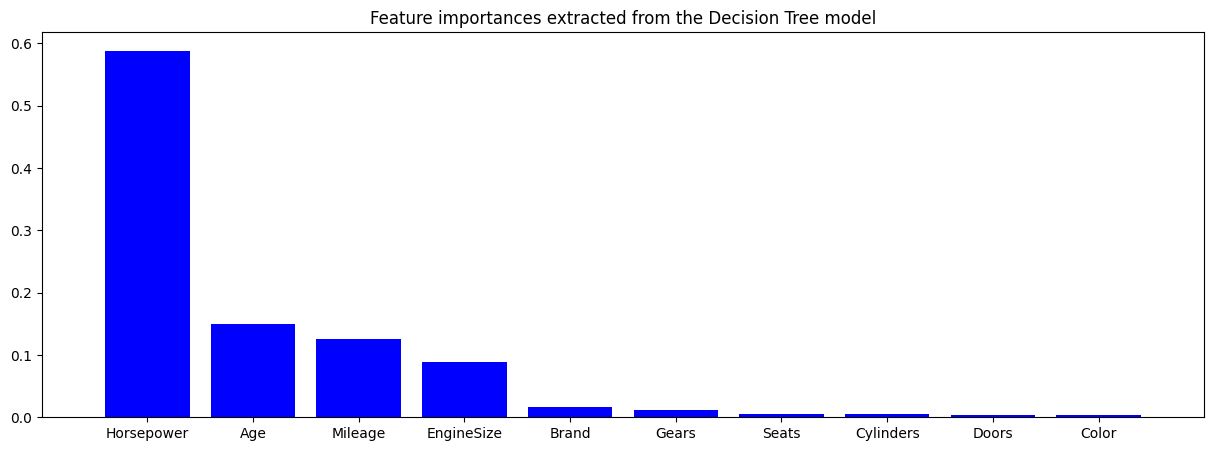

In [25]:
def plot_feature_importance(estimator, X, title, ax=None):
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X_train.columns.take(indices).tolist()
    
    plt.subplots(figsize=(15, 5))
    plt.title(title)
    plt.bar(range(X_train.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X_train.shape[1]), feature_names)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
plot_feature_importance(dt, X_train, "Feature importances extracted from the Decision Tree model")

As we have guessed based on the plot of our tree, the features *Horsepower* and *Age* are the most important ones.

## Random Forest
Let us check if we can beat the score of our model by using a Random Forest.

> Fit a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and use 10 decision trees.

In [26]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

We plot the learning curve as we did with the decision tree.

cross validation r2-score: 0.9229847339478645
training r2-score 0.9854454260713051


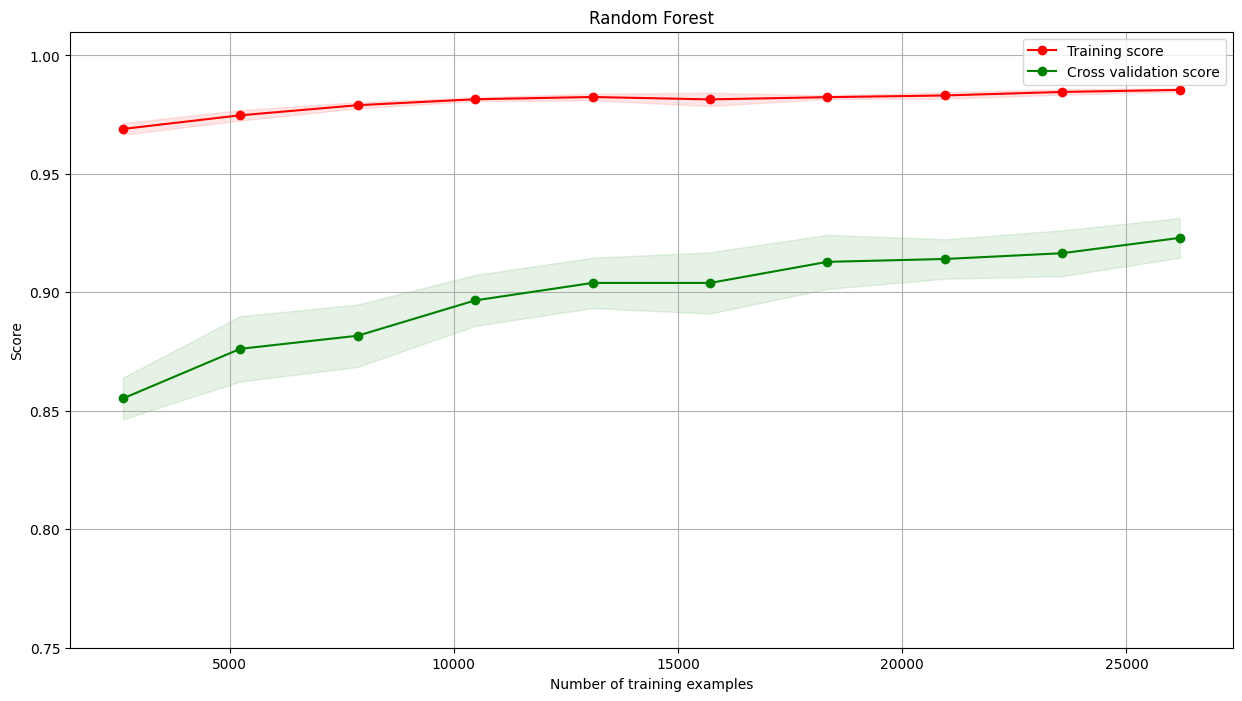

In [27]:
plot_learning_curve(rf, X_train, y_train, "Random Forest")

The gap between the training and the cross validation score is not as high as with the decision tree.

We still want to run a grid search to tune the parameters.

In [28]:
parameters = {
    "n_estimators": [10],
    "max_depth": range(5, 21),
    "min_samples_split": [2, 3, 4, 5, 6, 7]
}

gridSearch = GridSearchCV(rf, parameters, cv=5, scoring="r2", n_jobs=-1)
gridSearch.fit(X_test, y_test) ## HERE WE SHOULD NOT USE THE TEST SET!

print("Best score", gridSearch.best_score_)
print("Best params", gridSearch.best_params_)

Best score 0.9051082795448109
Best params {'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 10}


### Evaluate our model on the test set

In [29]:
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2:", r2)

r2: 0.9243261674790988


### Plot feature importance

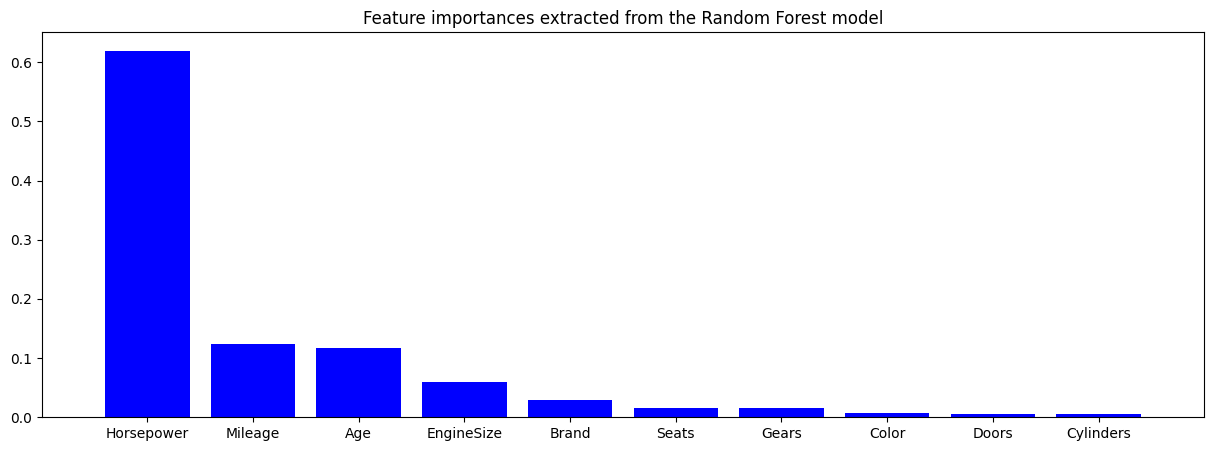

In [30]:
plot_feature_importance(rf, X_train, "Feature importances extracted from the Random Forest model")

When using a random forest model, the *Mileage* feature gets more weight than the *Age* feature.